In [4]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
from pulse2percept.viz import scatter_correlation
import shapes
from skimage import measure
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
data = shapes.load_shapes("../../data/shapes.h5", implant='ArgusII', stim_class=None)
data = data[data['electrode2'] == '']
# data = data[(data.stim_class != 'CDL0.35') & (data.stim_class != 'CDL0.75')]
data['props'] = data['image'].apply(lambda x : measure.regionprops(measure.label(x > 0.5)))
data.head()

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape,props
0,12-005,1.5,0.0,145,0.188493,20091028,0.936365,0.0,A2,,...,ArgusII,1,0.682111,0.45,SingleElectrode,9,102.857140,147.142853,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
1,12-005,1.5,0.0,174,0.165999,20091028,0.968756,0.0,A2,,...,ArgusII,1,0.324369,0.45,SingleElectrode,17,129.333328,160.666672,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
2,12-005,1.5,0.0,142,0.173824,20091028,0.871929,0.0,A2,,...,ArgusII,1,0.594180,0.45,SingleElectrode,30,151.000000,199.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
3,12-005,1.5,0.0,137,0.192119,20091028,0.925959,0.0,A2,,...,ArgusII,1,0.281614,0.45,SingleElectrode,38,256.000000,192.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...
4,12-005,1.5,0.0,133,0.217631,20091028,0.992635,0.0,A2,,...,ArgusII,1,0.609992,0.45,SingleElectrode,51,140.000000,218.000000,"(384, 512)",[<skimage.measure._regionprops.RegionPropertie...


In [6]:
def area(row, thresh=0.5):
    return np.sum(row.image > thresh)
def eccentricity(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.eccentricity
def axis_maj(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.major_axis_length
def axis_min(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    return prop.minor_axis_length
def axis_diff(row, thresh=0.5):
    prop = max(row.props, key = lambda x : x.area)
    try:
        return prop.major_axis_length / prop.minor_axis_length
    except ZeroDivisionError:
        return np.nan
ref_fns = [area, eccentricity, axis_maj, axis_min, axis_diff]

def get_ref(df, fn):
    return df.apply(lambda x: ref[x.subject][x.electrode1][ref_fns.index(fn)], axis=1)

In [4]:
group_cols = ['subject', 'electrode1', 'electrode2']
ref = {}
bad = []
for subject in data.subject.unique():
    ref[subject] = {}
    df = data[data.subject == subject]
    for elec1 in df.electrode1.unique():
        dfe = df[df.electrode1 == elec1]
        if subject != '52-001':
            ref_amp = 1.5
        else:
            ref_amp = 1.25
        dfe = dfe[(dfe.amp1 == ref_amp) & (dfe.freq == 20)]
        if len(dfe) == 0:
            # print(f"no reference for {subject} {elec1}")
            bad.append((subject, elec1))
            ref[subject][elec1] = tuple([np.nan for fn in ref_fns])
            continue
        ref_values = [np.mean(np.array(dfe.apply(fn, axis=1))) for fn in ref_fns]
        ref[subject][elec1] = tuple(ref_values)

# Analysis w/o model

### Helper fns

In [5]:
def plot_raw(data, fn, label=None, modulate='Amp', suplabel=None, remove_nonmodulated=True):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
        plt.title(subject)
        df = dat[dat.subject == subject]
        if modulate == 'Amp':
            xs = df['amp1']
        elif modulate == 'Freq':
            xs = df['freq']
        scatter_correlation(xs, df.apply(fn, axis=1), show_slope_intercept=True)
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    if modulate == 'Amp':
        xs = dat['amp1']
    elif modulate == 'Freq':
        xs = dat['freq']
    scatter_correlation(xs, dat.apply(fn, axis=1), show_slope_intercept=True)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs {fn.__name__}")
    plt.show()

In [6]:
def plot_averaged(data, fn, label=None, modulate='Amp', suplabel=None, remove_nonmodulated=True):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])   
        plt.title(subject)
        

        df = dat[dat.subject == subject]
        vals = df.apply(fn, axis=1)
        df['vals'] = vals
        avg_df = df.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean(numeric_only=False).reset_index()
        avg_vals = np.array(avg_df['vals'])
        if modulate == 'Amp':
            xs = avg_df['amp1']
        elif modulate == 'Freq':
            xs = avg_df['freq']
        scatter_correlation(xs, avg_vals, show_slope_intercept=True)
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
        
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    
    vals = dat.apply(fn, axis=1)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    scatter_correlation(xs, avg_vals, show_slope_intercept=True)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs averaged {fn.__name__}")
    plt.show()

In [347]:
def plot_relative_averaged(data, fn, suplabel=None, label=None, modulate='Amp', remove_nonmodulated=True, color=False, colorlabel=None, subplot_grid=(1, 4), subplot_figsize=(5, 20)):
    fig, axs = plt.subplots(subplot_grid[0], subplot_grid[1], figsize=subplot_figsize)
    if subplot_grid != (1, 4):
        axes = axs[0, :]
    else:
        axes = axs
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    
    for i, subject in enumerate(dat.subject.unique()):
        plt.sca(axes[i])
        plt.title(subject)
        df = dat[dat.subject == subject]
        vals = df.apply(fn, axis=1) / get_ref(df, fn)
        df['vals'] = vals
        avg_df = df.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
        avg_vals = avg_df['vals']
        if modulate == 'Amp':
            xs = avg_df['amp1']
        elif modulate == 'Freq':
            xs = avg_df['freq']
        if not color:
            scatter_correlation(xs, avg_vals, show_slope_intercept=True)
        else:
            isnan = np.isnan(xs) | np.isnan(avg_vals)
            xs_color = xs[~isnan]
            im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
        plt.xlabel(modulate)
        if label is not None:
            plt.ylabel(label)
        else:
            plt.ylabel(fn.__name__)
    
    # all subjects
    plt.sca(axes[3])
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    vals = dat.apply(fn, axis=1) / get_ref(data, fn)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    if not color:
        scatter_correlation(xs, avg_vals, show_slope_intercept=True)
    else:
        isnan = np.isnan(xs) | np.isnan(avg_vals)
        xs_color = xs[~isnan]
        im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs relative {fn.__name__}")
    if color:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
        cb = fig.colorbar(im, cax=cbar_ax)
        cb.set_label(colorlabel)
    return fig, axs

In [546]:
def plot_averaged_all(data, fn, suplabel=None, label=None, modulate='Amp', remove_nonmodulated=True, color=False, colorlabel=None, alpha=0.5, text_size=10):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    # all subjects
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    vals = dat.apply(fn, axis=1)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    if not color:
        scatter_correlation(xs, avg_vals, show_slope_intercept=True, marker_alpha=alpha, text_size=text_size)
    else:
        isnan = np.isnan(xs) | np.isnan(avg_vals)
        xs_color = xs[~isnan]
        im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
    # if suplabel is not None:
    #     fig.suptitle(suplabel)
    # else:
    #     fig.suptitle(f"{modulate} vs relative {fn.__name__}")
    if color:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
        cb = fig.colorbar(im, cax=cbar_ax)
        cb.set_label(colorlabel)

In [392]:
def plot_relative_averaged_all(data, fn, suplabel=None, label=None, modulate='Amp', remove_nonmodulated=True, color=False, colorlabel=None, alpha=0.5, text_size=10):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    # all subjects
    plt.xlabel(modulate)
    if label is not None:
        plt.ylabel(label)
    else:
        plt.ylabel(fn.__name__)
    plt.title('All Subjects')
    vals = dat.apply(fn, axis=1) / get_ref(data, fn)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    if modulate == 'Amp':
        xs = avg_df['amp1']
    elif modulate == 'Freq':
        xs = avg_df['freq']
    if not color:
        scatter_correlation(xs, avg_vals, show_slope_intercept=True, marker_alpha=alpha, text_size=text_size)
    else:
        isnan = np.isnan(xs) | np.isnan(avg_vals)
        xs_color = xs[~isnan]
        im = scatter_correlation(xs, avg_vals, show_slope_intercept=True, color=xs_color, marker_alpha=0.95)
    if suplabel is not None:
        fig.suptitle(suplabel)
    else:
        fig.suptitle(f"{modulate} vs relative {fn.__name__}")
    if color:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
        cb = fig.colorbar(im, cax=cbar_ax)
        cb.set_label(colorlabel)

## Amp vs Area

### Not relative

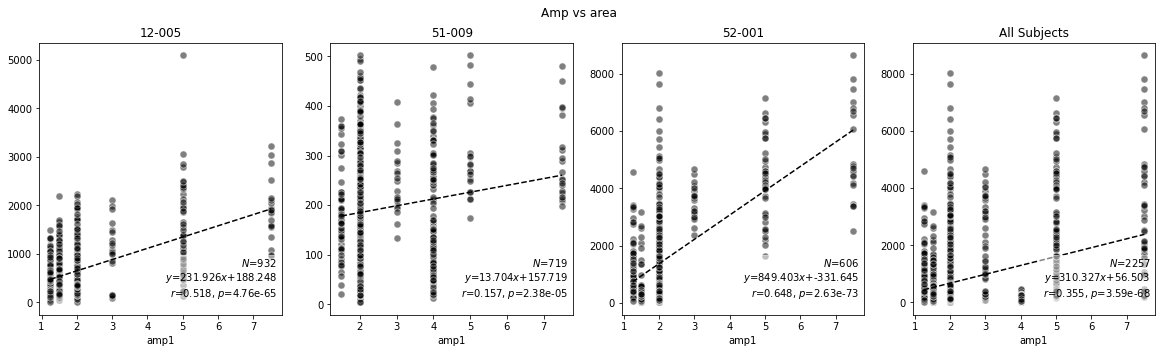

In [8]:
plot_raw(data, area)

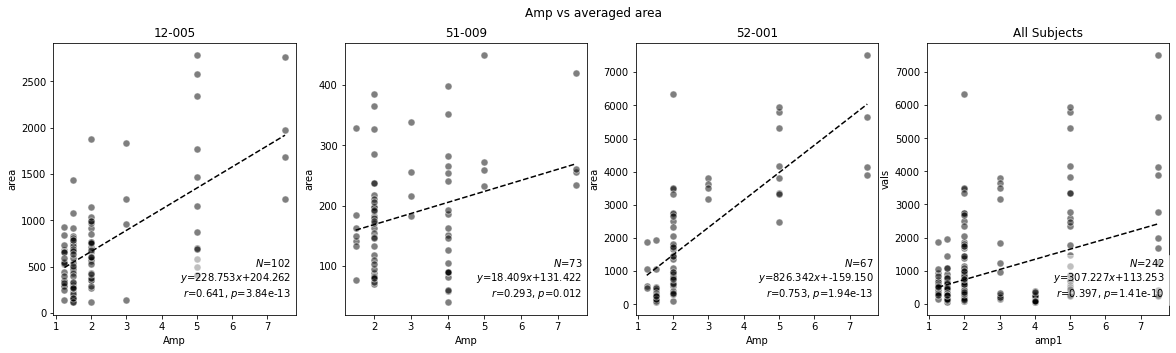

In [9]:
plot_averaged(data, area)

### Relative

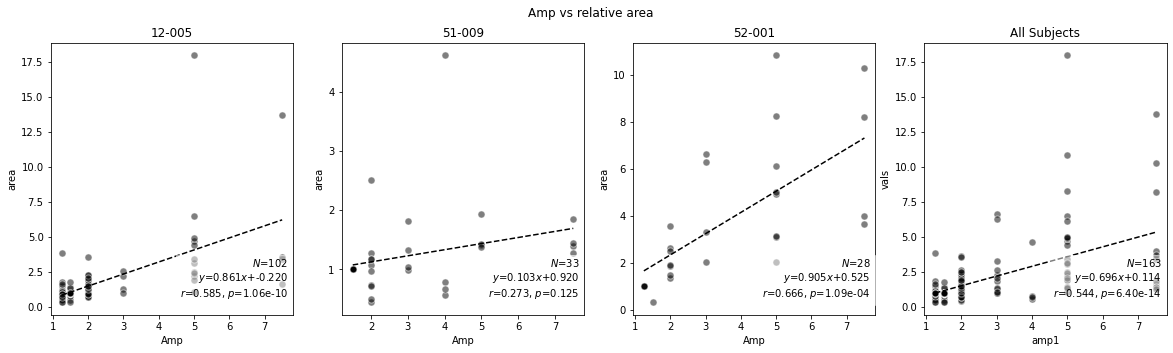

In [10]:
plot_relative_averaged(data, area)

## Freq vs area

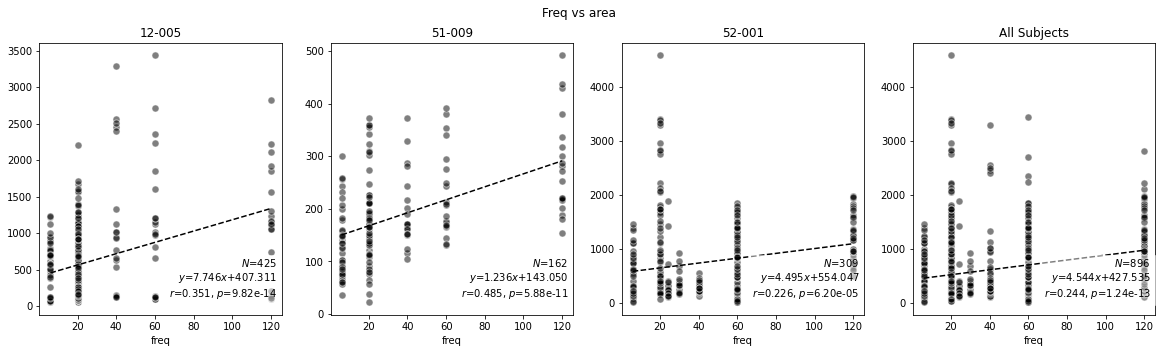

In [11]:
plot_raw(data, area, modulate='Freq')

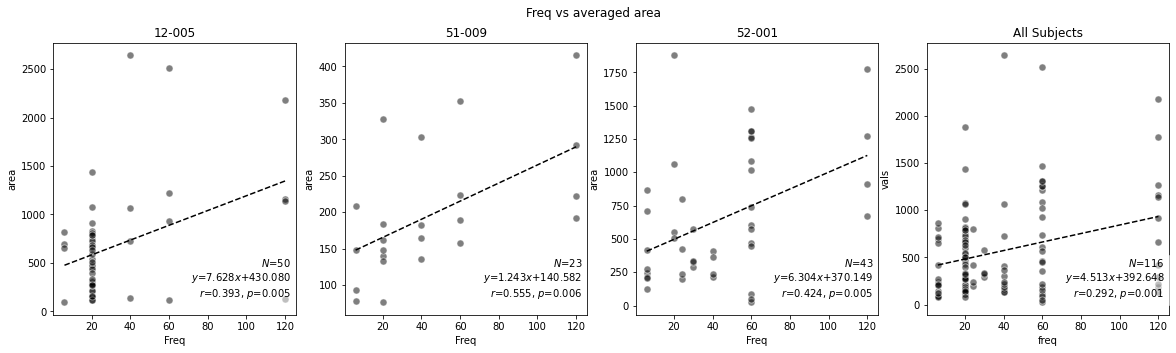

In [12]:
plot_averaged(data, area, modulate='Freq', remove_nonmodulated=True)

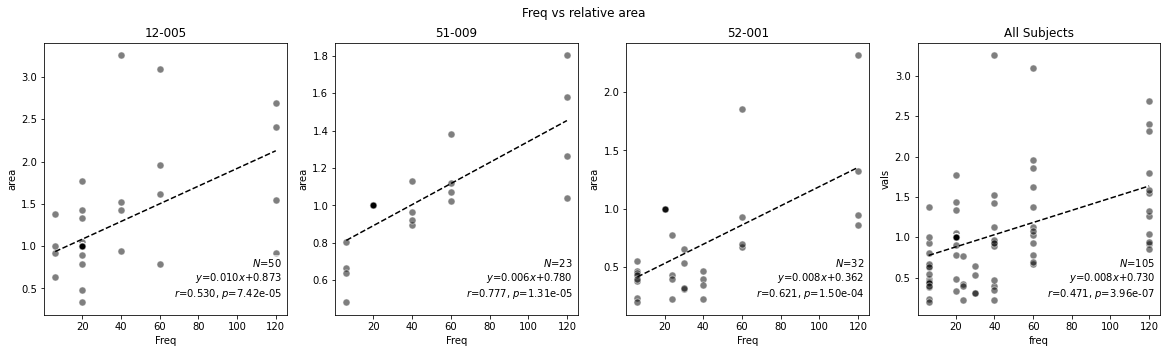

In [13]:
plot_relative_averaged(data, area, modulate='Freq', remove_nonmodulated=True)

## Streak Length

### Eccentricity 

#### Amp 

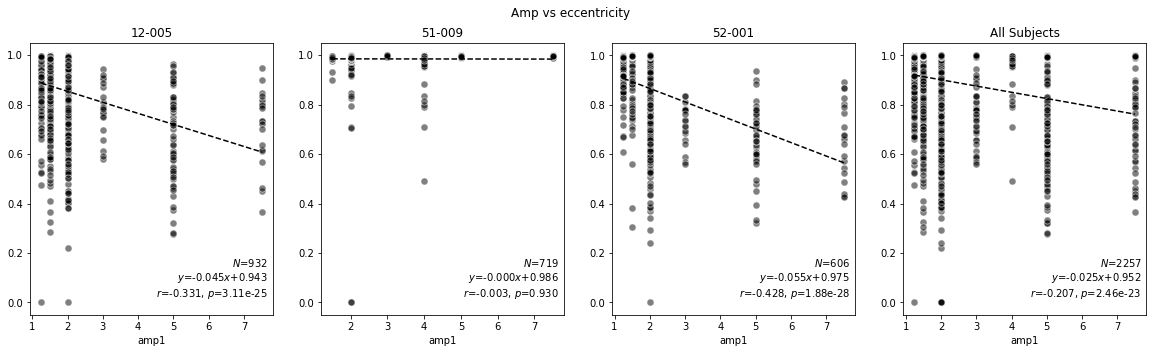

In [14]:
plot_raw(data, eccentricity)

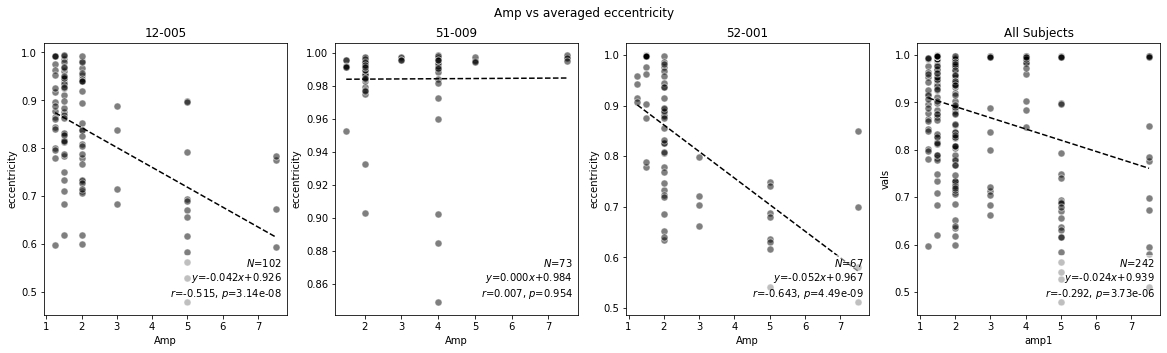

In [15]:
plot_averaged(data, eccentricity)

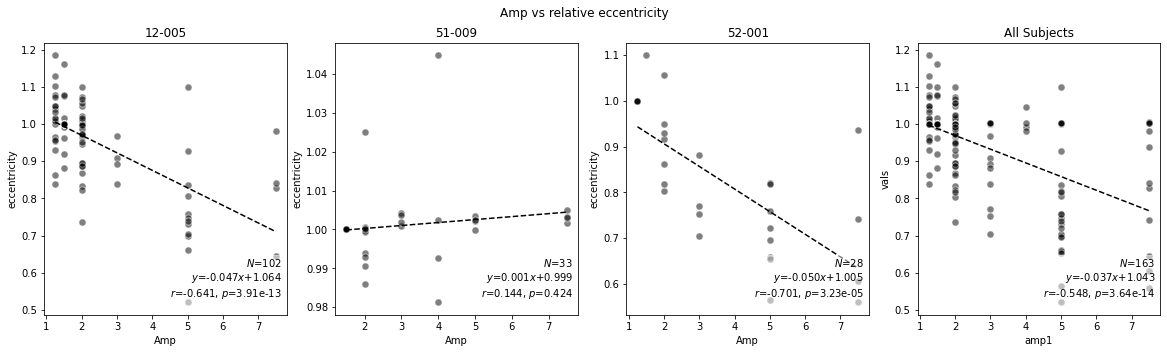

In [16]:
plot_relative_averaged(data, eccentricity)

#### Freq 

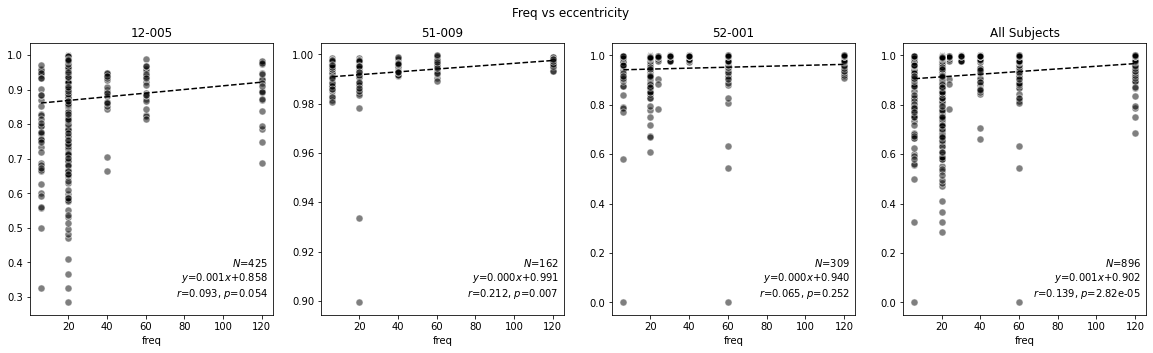

In [17]:
plot_raw(data, eccentricity, modulate='Freq')

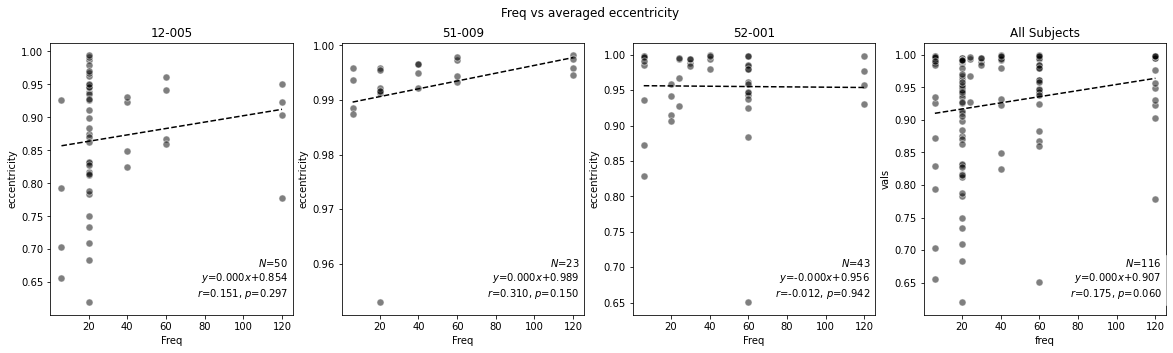

In [18]:
plot_averaged(data, eccentricity, modulate='Freq')

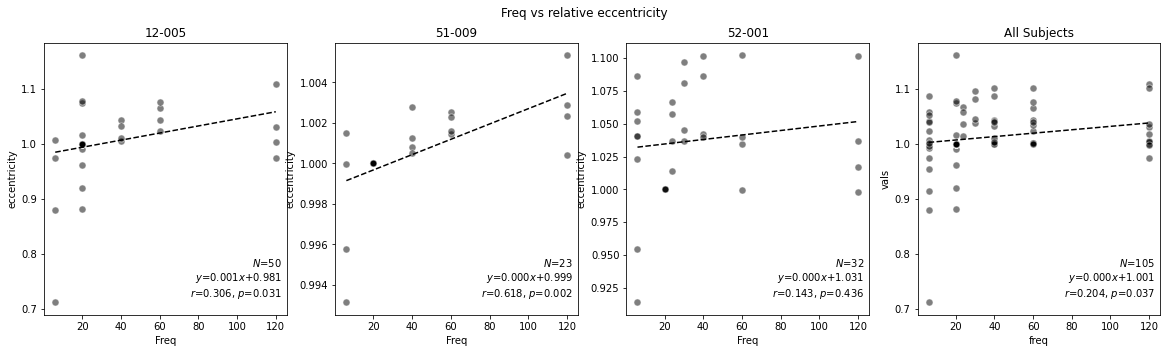

In [19]:
plot_relative_averaged(data, eccentricity, modulate='Freq')

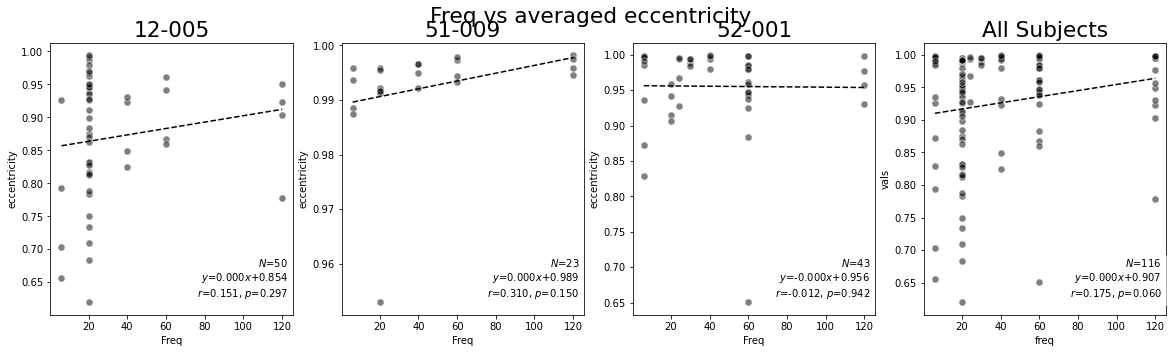

In [536]:
plot_averaged(data, eccentricity, modulate='Freq')

### Major Axis Length

#### Amp 

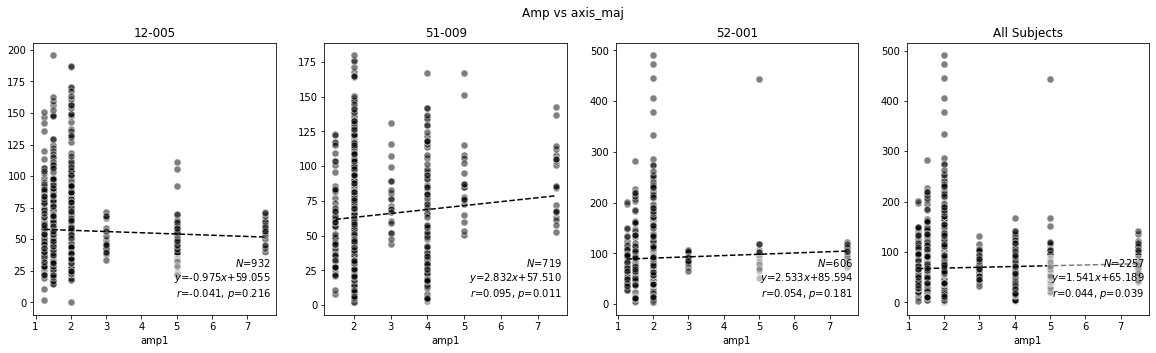

In [20]:
plot_raw(data, axis_maj)

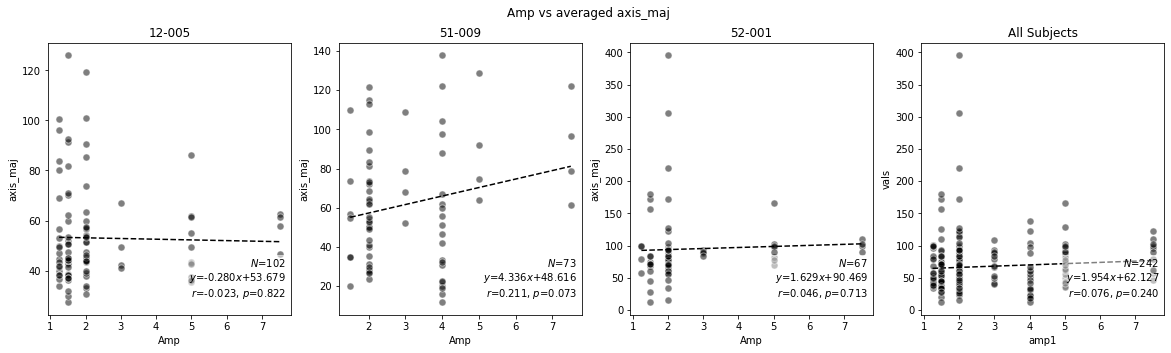

In [21]:
plot_averaged(data, axis_maj)

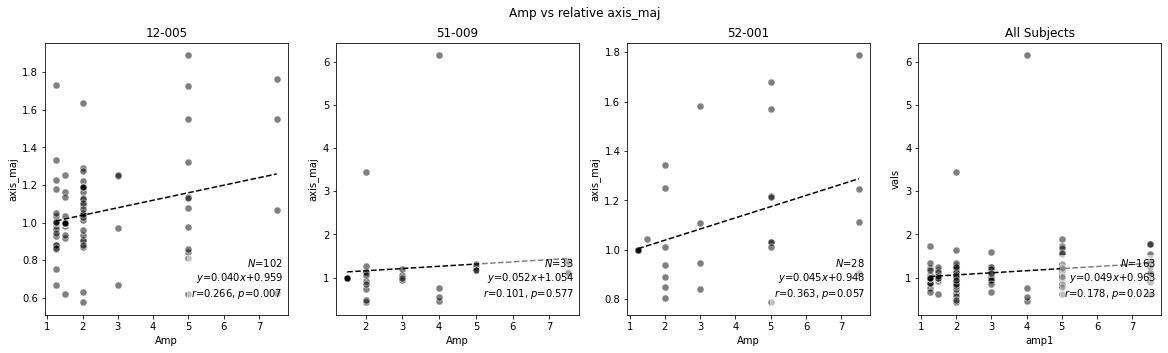

In [22]:
plot_relative_averaged(data, axis_maj)

#### Freq 

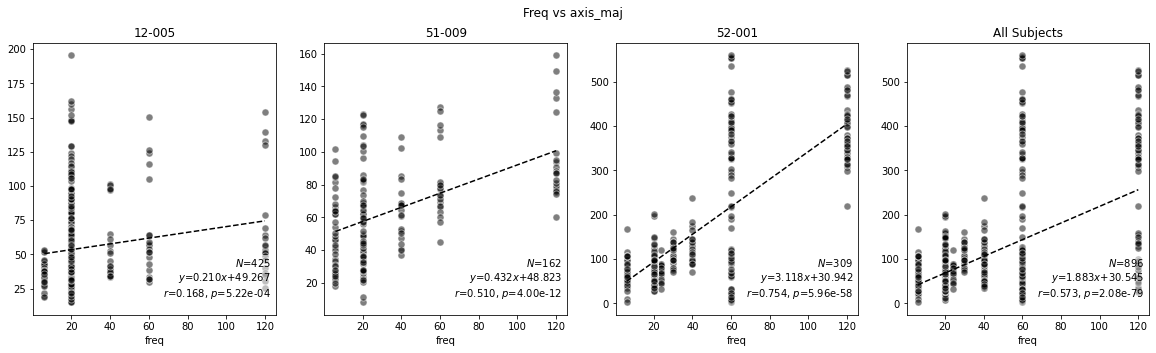

In [23]:
plot_raw(data, axis_maj, modulate='Freq')

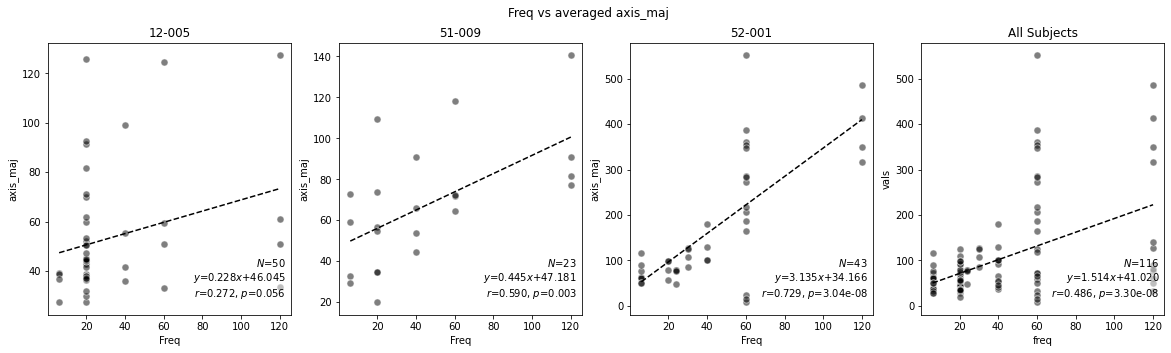

In [24]:
plot_averaged(data, axis_maj, modulate='Freq')

### Axis diff 

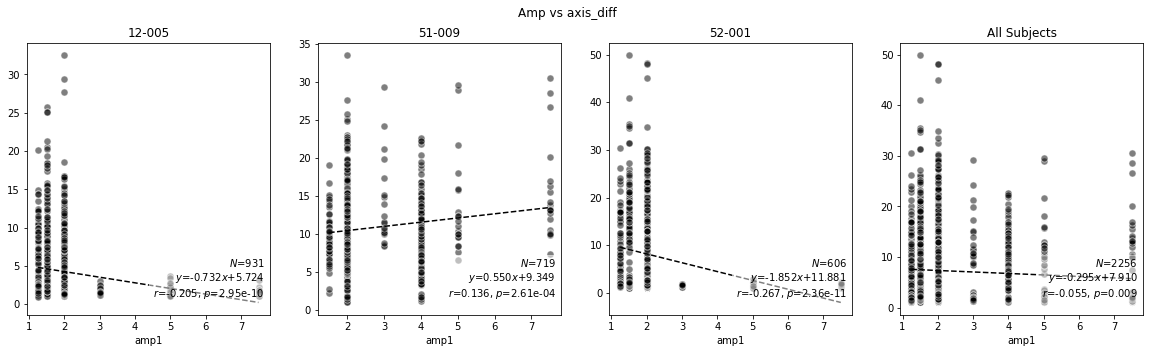

In [25]:
plot_raw(data, axis_diff)

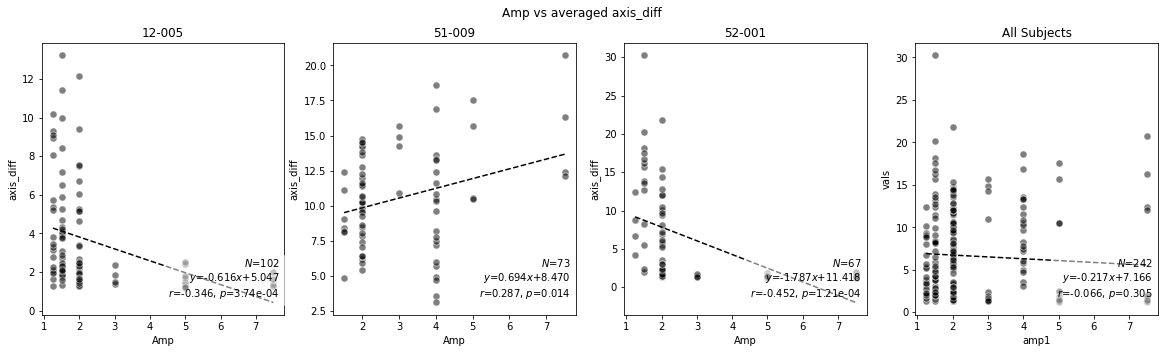

In [26]:
plot_averaged(data, axis_diff)

In [27]:
df = data[data.subject == '12-005']

In [28]:
df = df[df.freq == 20]

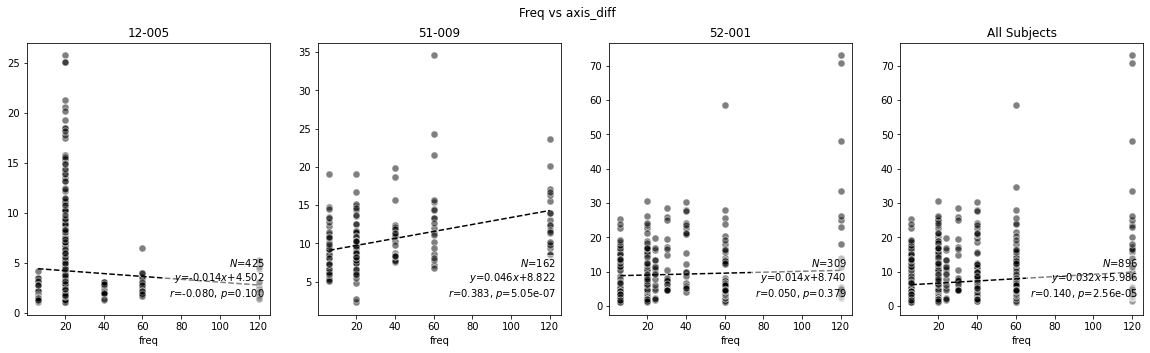

In [29]:
plot_raw(data, axis_diff, modulate='Freq')

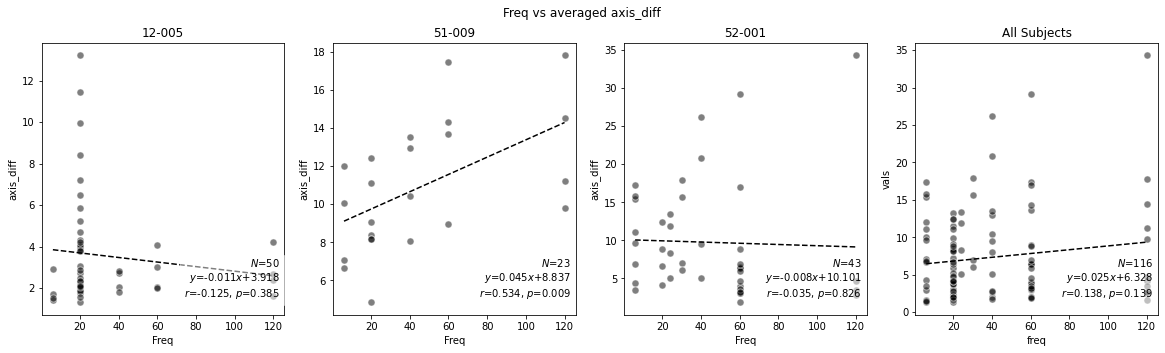

In [30]:
plot_averaged(data, axis_diff, modulate='Freq')

# Model

### Helper Functions

In [31]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.implants import ArgusII, DiskElectrode, ProsthesisSystem

from sklearn.linear_model import LinearRegression
import scipy.stats as spst
from sklearn.metrics import r2_score

In [32]:
def get_percept(row, model, implant):
    implant.stim = {row.electrode1 : BiphasicPulseTrain(row.freq, row.amp1, row.pdur)}
    return model.predict_percept(implant)

def phosphene_size(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
    return (percept.max(axis='frames') > ref_bright).sum()

def phosphene_eccentricity(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
    prop = max(measure.regionprops(measure.label(percept.max(axis='frames') > ref_bright)), key = lambda x : x.area)
    return prop.eccentricity

def phosphene_bright(percept):
    return percept.data.max()
    
model_ref_fns = [phosphene_size, phosphene_bright]
def get_model_ref(df, fn):
    return df.apply(lambda x: model_ref[x.subject][x.electrode1][model_ref_fns.index(fn)], axis=1)

In [33]:
def get_relative_averaged(data, fn, remove_nonmodulated=True, modulate='Amp'):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data
    vals = dat.apply(fn, axis=1) / get_ref(data, fn)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    return avg_df, avg_vals

In [34]:
def get_averaged(data, fn, remove_nonmodulated=True, modulate='Amp'):
    if remove_nonmodulated:
        if modulate == 'Amp':
            dat = data[data['freq'] == 20]
        elif modulate == 'Freq':
            dat = data[((data['amp1'] == 1.5) & (data.subject.isin(['12-005', '51-009']))) |  ((data['amp1'] == 1.25) & (data.subject == '52-001'))]
    else:
        dat = data

    vals = dat.apply(fn, axis=1)
    dat['vals'] = vals
    avg_df = dat.groupby(['implant', 'subject', 'amp1', 'amp2', 'electrode1', 'electrode2', 'freq', 'pdur', 'stim_class'])['vals'].mean().reset_index()
    avg_vals = avg_df['vals']
    return avg_df, avg_vals

In [35]:
model_ref = {}
rholambdas = {  '12-005' : (410, 1190, 0.8606007300451295, -0.22009792182424115),
                '51-009' : (144, 1414, 0.10317693634692716, 0.9195175629336384),
                '52-001' : (437, 1420, 0.9053663293316979, 0.5252074767108121)}
for subject in data.subject.unique():
    model_ref[subject] = {}
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    model.build()
    df = data[data.subject == subject]
    for elec1 in df.electrode1.unique():
        dfe = df[df.electrode1 == elec1]
        if subject != '52-001':
            ref_amp = 1.5
        else:
            ref_amp = 1.25
        
        implant.stim = {elec1 : BiphasicPulseTrain(20, ref_amp, 0.45)}
        ref_percept = model.predict_percept(implant)
        ref_bright = ref_percept.data.max()
        ref_size = phosphene_size(ref_percept)
        
        model_ref[subject][elec1] = (ref_size, ref_bright)

## Amp vs Size

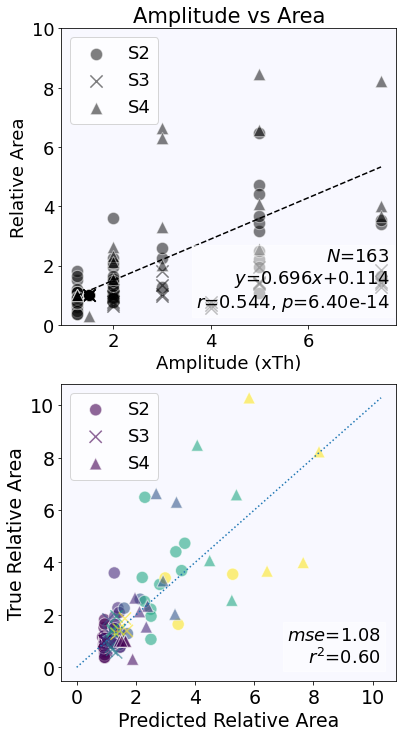

In [566]:
# fig, axs = plot_relative_averaged(data, area, subplot_grid=(2, 4), subplot_figsize=(20, 10))
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
# plt.subplots_adjust(hspace=0.25)
plt.sca(axes[0])
plt.rcParams['font.size'] = '18'
plot_relative_averaged_all(data, area, alpha=0, text_size=plt.rcParams['font.size'])
markersize=150


snames, markers = ['S2', 'S3', 'S4'], ['o', 'x', '^']
plt.xlabel("Amplitude (xTh)")
plt.ylabel("Relative Area")
plt.title("Amplitude vs Area", fontsize=21)
# plt.title("")
plt.ylim(0, 10)
axes[0].set_facecolor('ghostwhite')
axes[1].set_facecolor('ghostwhite')

bad_elecs = {'12-005' : ['D7'], '51-009' : ['F4'], '52-001':[]}
all_sizes = []
all_model_sizes = []
all_amps = []
for i, (subject, sname, smarker) in enumerate(zip(data.subject.unique(), snames, markers)):
    # get points
    df = data[data.subject == subject]
    df = df[df.freq == 20]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_relative_averaged(df, area, modulate='Amp')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['areas'] = avg_areas
    amps = avg_df.amp1
    plt.scatter(amps, avg_areas, color='k', alpha=0.5, marker=smarker, label=sname, edgecolors='w', s=markersize)
    
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    # lr = LinearRegression()
    # lr.fit(np.array(amps).reshape(-1, 1), np.array(avg_areas))
    # model.a5 = lr.coef_[0]
    # model.a6 = lr.intercept_
    # print(model.a5, model.a6)
    if subject == '52-001':
        model.a5 = 1.708
        model.a6 = 0.648
    elif subject == '12-005':
        model.a5 =  0.802
        model.a6 =  -0.031
    elif subject == '51-009':
        model.a5 = 0.152
        model.a6 = 0.78
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['sizes'] = avg_df.percept.apply(phosphene_size) / get_model_ref(avg_df, phosphene_size)
    mse = np.mean((avg_df.sizes - avg_areas)**2)
    
    # plt.sca(axes[0, i])
    # plt.scatter(amps, avg_areas, alpha=0.6)
    
    avg_drawing_sizes = avg_df.groupby(['amp1'])['areas'].mean()
    std_drawing_sizes = avg_df.groupby(['amp1'])['areas'].std()
    avg_drawing_amps = avg_df.groupby(['amp1'])['areas'].mean().reset_index()['amp1']
    # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
    # plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
    # means = avg_df.groupby(['amp1'])['sizes'].mean()
    # stds = avg_df.groupby(['amp1'])['sizes'].std()
    # amps = avg_df.groupby(['amp1'])['sizes'].mean().reset_index()['amp1'].unique()
    # plt.errorbar(amps, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
    # plt.plot(amps, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
    # plt.ylabel('Relative Size')
    # plt.xlabel('Amp (xTh)')
    # plt.legend()
    
    
    # plt.sca(axes[i])
    # plt.scatter(avg_df['sizes'], avg_areas, c=avg_df['amp1'], alpha=0.6)
    all_model_sizes.append(avg_df['sizes'])
    all_sizes.append(avg_areas)
    all_amps.append(avg_df['amp1'])
    # for x, y, elec in zip(avg_df['sizes'], avg_areas, avg_df.electrode1):
    #     plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    # maxval = max(avg_df['sizes'].max(), avg_areas.max())
    # plt.plot( [0,maxval],[0,maxval] , linestyle=':', color='gray')
    
    mse = np.mean((avg_areas - avg_df['sizes'])**2)
    r = r2_score(avg_areas, avg_df['sizes'])
    # t = plt.text(maxval, maxval*0.05, f"$mse$={mse:.2f}\n$r^2$={r:.2f}", va='bottom', ha='right')
    
    # plt.xlabel('Predicted relative size')
    # plt.ylabel('Actual relative size')
    # plt.title(subject)
plt.legend()
plt.sca(axes[1])
for i, (subject, marker) in enumerate(zip(['S2', 'S3', 'S4'], ['o', 'x', '^'])):
    im = plt.scatter(all_model_sizes[i], all_sizes[i], c=all_amps[i], marker=marker, alpha=0.6, label=subject, s=markersize, cmap='viridis', edgecolors='w')
plt.legend()
plt.xlabel('Predicted Relative Area')
plt.ylabel('True Relative Area')
# plt.title('Predicted vs True Area')


all_areas = np.concatenate(all_sizes)
all_model_areas = np.concatenate(all_model_sizes)
mse = np.mean((all_areas - all_model_areas)**2)
r = r2_score(all_areas, all_model_areas)
maxval = max([all_areas.max(), all_model_areas.max()])
plt.plot([0, maxval], [0, maxval], linestyle=':')
t = plt.text(maxval, 0, f"$mse$={mse:.2f}\n$r^2$={r:.2f}", va='bottom', ha='right')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.125, 0.04, 0.75])
# cb = fig.colorbar(im, cax=cbar_ax, )
# cb.set_label("Amplitude (xTh)")#, rotation=0, y=-0.04, labelpad=-30)

plt.savefig('figures/ampvarea.png',bbox_inches='tight', dpi=300)
fig_ava = fig
axes_ava = axes

In [37]:
def model_mse(a5a6, model, implant, data):
    a5 = a5a6[0]
    a6 = a5a6[1]
    model.a5 = a5
    model.a6 = a6
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['sizes'] = data.percepts.apply(phosphene_size) / get_model_ref(data, phosphene_size)
    
    return np.mean((data.sizes - data.areas)**2)
        

In [38]:
# from scipy.optimize import minimize, differential_evolution
# sols = []
# for subject in data.subject.unique():
    
#     implant, model = shapes.model_from_params(shapes.subject_params[subject])
#     model.rho = rholambdas[subject][0]
#     model.axlambda = rholambdas[subject][1]
#     model.build()


#     df = data[data.subject == subject]
#     df = df[df.freq == 20]
#     df = df[~df.electrode1.isin(bad_elecs[subject])]
#     avg_df, avg_areas = get_relative_averaged(df, area, modulate='Amp')
#     avg_df = avg_df.dropna()
#     avg_areas = avg_areas.dropna()
#     avg_df['areas'] = avg_areas
    
#     sol = differential_evolution(model_mse, ((0, 5), (-5, 5), (10, 500)), args=(model, implant, avg_df), maxiter=100, popsize=10)
#     print(sol)
#     sols.append(sol)

# model_mse([1.717, -0.71], model, implant, avg_df)

## Freq vs Size

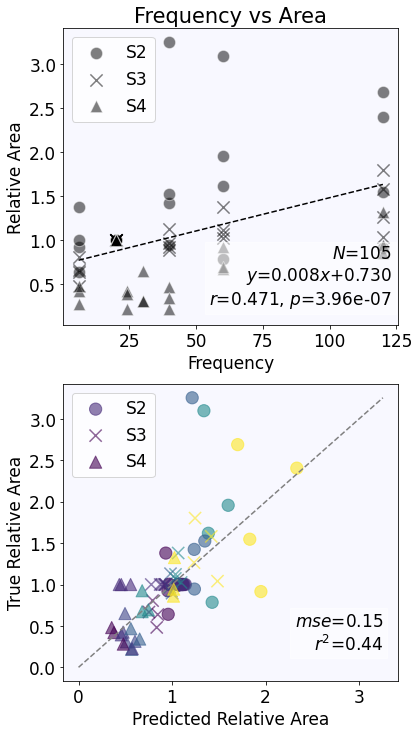

In [599]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
# plt.subplots_adjust(hspace=0.25)
plt.sca(axes[0])
plt.rcParams['font.size'] = '17'
markersize=150
plot_relative_averaged_all(data, area, modulate='Freq', text_size=plt.rcParams['font.size'], alpha=0)
plt.title("Frequency vs Area", fontsize=21)
plt.xlabel('Frequency')
plt.ylabel('Relative Area')

axes[0].set_facecolor('ghostwhite')
axes[1].set_facecolor('ghostwhite')

rholambdas = {  '12-005' : (410, 1190, 0.802, -0.031),
                '51-009' : (144, 1414, 0.152, 0.78),
                '52-001' : (437, 1420, 1.708, 0.648)}
bad_elecs = {'12-005' : [], '51-009' : [], '52-001':['E5']}
subj_data = []
for i, (subject, sname, smarker) in enumerate(zip(data.subject.unique(), snames, markers)):
    # get points
    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_areas = get_relative_averaged(df, area, modulate='Freq')
    avg_df = avg_df.dropna()
    avg_areas = avg_areas.dropna()
    avg_df['areas'] = avg_areas
    freqs = avg_df.freq
    plt.scatter(freqs, avg_areas, color='k', alpha=0.5, marker=smarker, label=sname, edgecolors='w', s=markersize)
    
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    # lr = LinearRegression()
    # lr.fit(np.array(freqs).reshape(-1, 1), np.array(avg_areas))
    # model.a10 = lr.coef_[0]
    # model.a6 = lr.intercept_

    
    if subject == '12-005':
        model.a6, model.a10 = -0.2829508668414943, 0.01386980325453202
    elif subject == '51-009':
        model.a6, model.a10 = 0.5385426635343504, 0.006992905321139498
    elif subject == '52-001':
        model.a6, model.a10 = -1.6310288461517213, 0.00992617959193387
        #0.017678352500785532, 0#-0.04803093261331881
    # print(model.a10)
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['sizes'] = avg_df.percept.apply(phosphene_size) / get_model_ref(avg_df, phosphene_size)
    mse = np.mean((avg_df.sizes - avg_areas)**2)
    
    # plt.sca(axes[0, i])
    
    # scatterplot with areas, model line plot
#     plt.scatter(freqs, avg_areas, alpha=0.6)
    
#     avg_drawing_sizes = avg_df.groupby(['freq'])['areas'].mean()
#     std_drawing_sizes = avg_df.groupby(['freq'])['areas'].std()
#     avg_drawing_amps = avg_df.groupby(['freq'])['areas'].mean().reset_index()['freq']
    # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
    # plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
    # means = avg_df.groupby(['freq'])['sizes'].mean()
    # stds = avg_df.groupby(['freq'])['sizes'].std()
    # freqs = avg_df.groupby(['freq'])['sizes'].mean().reset_index()['freq'].unique()
    # plt.errorbar(freqs, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
    # plt.plot(freqs, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
    # plt.ylabel('Relative Size')
    # plt.xlabel('Freq (Hz)')
    # plt.legend()
    
    
    # plt.sca(axes[i])
    # plt.scatter(avg_df['sizes'], avg_areas, c=avg_df['freq'])
    
    
    # for x, y, elec in zip(avg_df['sizes'], avg_areas, avg_df.electrode1):
    #     plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    # maxval = max(avg_df['sizes'].max(), avg_areas.max())
    # plt.plot( [0,maxval],[0,maxval] , linestyle='--', color='gray')
    
    # get r2 for model
#     r = r2_score(avg_areas, avg_df.sizes)
#     a = plt.gca().axis()
#     t = plt.text(maxval, maxval*0.05, f"$mse$={mse:.2f}\n $r^2$={r:.2f}", va='bottom', ha='right')
#     t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))
    
#     plt.xlabel('Predicted relative size')
#     plt.ylabel('Actual relative size')
#     plt.title(subject)
    
    subj_data.append([avg_areas, avg_df.sizes, avg_df.freq])
plt.legend()
plt.sca(axes[1])
maxval = max([max(np.max(row[0]), np.max(row[1])) for row in subj_data])
all_areas = []
all_model_areas = []
for (areas, model_areas, freqs), marker, subject in zip(subj_data, markers, ['S2', 'S3', 'S4']):
    im = plt.scatter(model_areas, areas, c=freqs, marker=marker, label=subject, s=markersize, alpha=0.6)
    all_areas += list(areas)
    all_model_areas += list(model_areas)
plt.plot( [0,maxval],[0,maxval] , linestyle='--', color='gray')
plt.xlabel('Predicted Relative Area')
plt.ylabel('True Relative Area')
# plt.title("All Subjects")
plt.title("")
plt.legend()


all_areas = np.array(all_areas)
all_model_areas = np.array(all_model_areas)
mse = np.mean((all_areas - all_model_areas)**2)
r = r2_score(all_areas, all_model_areas)

a = plt.gca().axis()
t = plt.text(maxval, maxval*0.05, f"$mse$={mse:.2f}\n$r^2$={r:.2f}", va='bottom', ha='right')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.set_label("Frequency")#, rotation=0, y=-0.04, labelpad=-30)

plt.savefig('figures/freqvarea.png',bbox_inches='tight', dpi=800)
fig_fva = fig
axes_fva = axes

In [40]:
def model_mse(a6a10, model, implant, data):
    a6 = a6a10[0]
    a10 = a6a10[1]
    model.a6 = a6
    model.a10 = a10
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['sizes'] = data.percepts.apply(phosphene_size) / get_model_ref(data, phosphene_size)
    
    return np.mean((data.sizes - data.areas)**2)
        

In [41]:
# from scipy.optimize import minimize, differential_evolution
# sols = {}
# for subject in data.subject.unique():
#     print(subject)
#     implant, model = shapes.model_from_params(shapes.subject_params[subject])
#     model.rho = rholambdas[subject][0]
#     model.axlambda = rholambdas[subject][1]
#     model.a5 = rholambdas[subject][2]
#     model.build()


#     df = data[data.subject == subject]
#     df = df[~df.electrode1.isin(bad_elecs[subject])]
#     avg_df, avg_areas = get_relative_averaged(df, area, modulate='Freq')
#     avg_df = avg_df.dropna()
#     avg_areas = avg_areas.dropna()
#     avg_df['areas'] = avg_areas
    
#     sol = differential_evolution(model_mse, ((-5, 5), (0, 2)), args=(model, implant, avg_df), maxiter=100, popsize=10)
#     print(sol)
#     print()
#     sols[subject] = sol

# model_mse([1.717, -0.71], model, implant, avg_df)

In [42]:
# [list(s.x) for s in sols]

## Amp vs Eccentricity

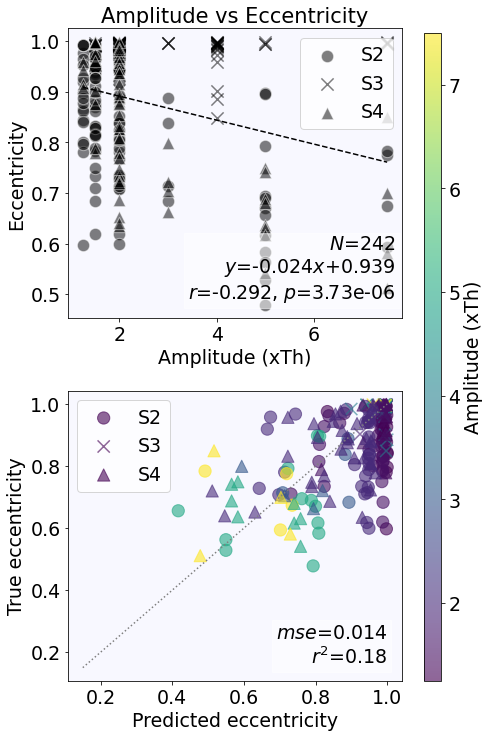

In [570]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
plt.subplots_adjust(hspace=0.25)
plt.sca(axes[0])
plt.rcParams['font.size'] = '19'
markersize=150
plot_averaged_all(data, eccentricity, modulate='Amp', text_size=plt.rcParams['font.size'], alpha=0)
plt.title("Amplitude vs Eccentricity", fontsize=21)
plt.xlabel('Amplitude (xTh)')
plt.ylabel('Eccentricity')

axes[0].set_facecolor('ghostwhite')
axes[1].set_facecolor('ghostwhite')

rholambdas = {  '12-005' : (410, 1190, 0.802, -0.031, 0.01386980325453202),
                '51-009' : (144, 1414, 0.152, 0.78, 0.006992905321139498),
                '52-001' : (437, 1420, 1.708, 0.648, 0.00992617959193387)}
bad_elecs = {'12-005' : [], '51-009' : ['B4'], '52-001':[]}
subj_data = []
for i, (subject, sname, smarker) in enumerate(zip(data.subject.unique(), snames, markers)):
    # get points
    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_ecc = get_averaged(df, eccentricity, modulate='Amp')
    avg_df = avg_df.dropna()
    avg_ecc = avg_ecc.dropna()
    avg_df['ecc'] = avg_ecc
    amps = avg_df.amp1
    plt.scatter(amps, avg_ecc, color='k', alpha=0.5, marker=smarker, label=sname, edgecolors='w', s=markersize)
    
    # fit the model
    implant, model = shapes.model_from_params(shapes.subject_params[subject])
    model.rho = rholambdas[subject][0]
    model.axlambda = rholambdas[subject][1]
    model.a5 = rholambdas[subject][2]
    model.a6 = rholambdas[subject][3]
    model.a10=rholambdas[subject][4]
    # lr = LinearRegression()
    # lr.fit(np.array(freqs).reshape(-1, 1), np.array(avg_areas))
    # model.a10 = lr.coef_[0]
    # model.a6 = lr.intercept_
    
    if subject == '12-005':
        model.a5, model.a6, model.a10 = 0.43872050801986984, -3.7321742476913258,0.15642703888564258,
        model.axlambda, model.rho = 621.7104851907188, 234.20288368721737
    elif subject == '51-009':
        model.a5, model.a6, model.a10 = 0.006201963689117629, -4.6850412463599795, 0.23452185555251748,
        model.axlambda = 2698.6802981005285
    elif subject == '52-001':
        model.a5, model.a6, model.a10 = 0.3671297821907702, -2.0222138114347055, 0.07394651794302004,
        model.axlambda = 1346.1789052198671
        #0.017678352500785532, 0#-0.04803093261331881
    # # print(model.a10)
    # model.a5 = sols[subject].x[0]
    # model.a6 = sols[subject].x[1]
    # model.a10 = sols[subject].x[2]
    # model.axlambda = sols[subject].x[3]
    
    model.build()
    
    # simulate percepts
    avg_df['percept'] = avg_df.apply(get_percept, args=(model, implant), axis=1)
    
    avg_df['model_ecc'] = avg_df.percept.apply(phosphene_eccentricity)
    mse = np.mean((avg_df.model_ecc - avg_ecc)**2)
    
#     plt.sca(axes[0, i])
    
#     # scatterplot with areas, model line plot
#     plt.scatter(amps, avg_ecc, alpha=0.6)
    
# #     avg_drawing_sizes = avg_df.groupby(['freq'])['areas'].mean()
# #     std_drawing_sizes = avg_df.groupby(['freq'])['areas'].std()
# #     avg_drawing_amps = avg_df.groupby(['freq'])['areas'].mean().reset_index()['freq']
#     # plt.scatter(avg_drawing_amps, avg_drawing_sizes, alpha=0.8)
#     # plt.errorbar(avg_drawing_amps, avg_drawing_sizes, yerr=std_drawing_sizes, linestyle='', marker='o', capsize=5, capthick=2, label='Data')
    
#     means = avg_df.groupby(['amp1'])['model_ecc'].mean()
#     stds = avg_df.groupby(['amp1'])['model_ecc'].std()
#     amps1 = avg_df.groupby(['amp1'])['model_ecc'].mean().reset_index()['amp1'].unique()
#     plt.errorbar(amps1, means, yerr=stds, marker='+', color='black', ecolor='red', capsize=5, capthick=2, label=f"Model, mse: {mse : .2f}")
#     plt.plot(amps1, means, c='black', marker='+', label=f"Model, mse: {mse : .2f}")
    
#     plt.ylabel('Relative Size')
#     plt.xlabel('Freq (Hz)')
#     plt.legend()
    
    
#     plt.sca(axes[i])
#     plt.scatter(avg_df['model_ecc'], avg_ecc, c=avg_df['amp1'])
    
    
#     for x, y, elec in zip(avg_df['model_ecc'], avg_ecc, avg_df.electrode1):
#         plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
#     maxval = max(avg_df['model_ecc'].max(), avg_ecc.max())
#     minval = min(avg_df['model_ecc'].min(), avg_ecc.min())
#     minval = min(minval, 0.8)
#     plt.plot( [minval,maxval],[minval,maxval] , linestyle='--', color='gray')
    
#     # get r2 for model
#     r = r2_score(avg_ecc, avg_df.model_ecc)
#     a = plt.gca().axis()
#     t = plt.text(maxval, minval, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')
#     t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))
    
#     plt.xlabel('Predicted eccentricity')
#     plt.ylabel('Actual eccentricity')
#     plt.title(subject)
    
    subj_data.append([avg_ecc, avg_df.model_ecc, avg_df.amp1])
plt.legend(loc='upper right')
plt.sca(axes[1])
maxval = max([max(np.max(row[0]), np.max(row[1])) for row in subj_data])
minval = min([min(np.min(row[0]), np.min(row[1])) for row in subj_data])
all_areas = []
all_model_areas = []
for (areas, model_areas, freqs), marker, subject in zip(subj_data, markers, snames):
    im = plt.scatter(model_areas, areas, c=freqs, marker=marker, label=subject, alpha=0.6, s=markersize)
    all_areas += list(areas)
    all_model_areas += list(model_areas)
plt.plot( [0.15,maxval],[0.15,maxval] , linestyle=':', color='gray')
plt.xlabel('Predicted eccentricity')
plt.ylabel('True eccentricity')
# plt.title("All Subjects")
plt.legend()


all_areas = np.array(all_areas)
all_model_areas = np.array(all_model_areas)
mse = np.mean((all_areas - all_model_areas)**2)
r = r2_score(all_areas, all_model_areas)

a = plt.gca().axis()
t = plt.text(maxval, 0.15, f"$mse$={mse:.3f}\n$r^2$={r:.2f}", va='bottom', ha='right')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha=0.5))

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.125, 0.04, 0.75])
cb = fig.colorbar(im, cax=cbar_ax, )
cb.set_label("Amplitude (xTh)")#, rotation=0, y=-0.04, labelpad=-30)

plt.savefig('figures/ampvecc.png',bbox_inches='tight', dpi=800)
fig_ave = fig
axes_ave = axes

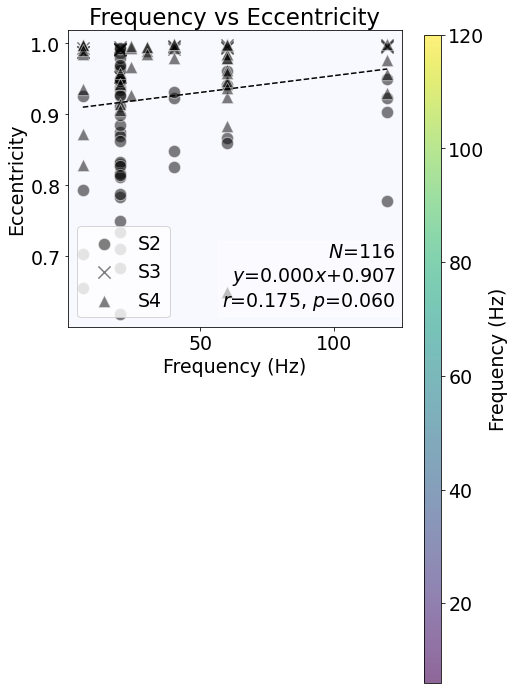

In [600]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
plt.sca(axes[0])
plt.rcParams['font.size'] = '19'
markersize=150
plot_averaged_all(data, eccentricity, modulate='Freq', text_size=plt.rcParams['font.size'], alpha=0)
# plt.title("Amplitude vs Eccentricity", fontsize=21)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Eccentricity')

plt.gca().set_facecolor('ghostwhite')

rholambdas = {  '12-005' : (410, 1190, 0.802, -0.031, 0.01386980325453202),
                '51-009' : (144, 1414, 0.152, 0.78, 0.006992905321139498),
                '52-001' : (437, 1420, 1.708, 0.648, 0.00992617959193387)}
bad_elecs = {'12-005' : [], '51-009' : ['B4'], '52-001':[]}
subj_data = []
for i, (subject, sname, smarker) in enumerate(zip(data.subject.unique(), snames, markers)):
    # get points
    df = data[data.subject == subject]
    df = df[~df.electrode1.isin(bad_elecs[subject])]
    avg_df, avg_ecc = get_averaged(df, eccentricity, modulate='Freq')
    avg_df = avg_df.dropna()
    avg_ecc = avg_ecc.dropna()
    avg_df['ecc'] = avg_ecc
    freqs = avg_df.freq
    plt.scatter(freqs, avg_ecc, color='k', alpha=0.5, marker=smarker, label=sname, edgecolors='w', s=markersize)
plt.legend(loc='lower left')
plt.title('Frequency vs Eccentricity')



fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.125, 0.04, 0.75])
cb = fig.colorbar(im, cax=cbar_ax, )
cb.set_label("Frequency (Hz)")#, rotation=0, y=-0.04, labelpad=-30)

plt.sca(axes[1])
plt.axis('off')

plt.savefig('figures/freqvecc.png', dpi=400, bbox_inches='tight')
fig_fve = fig
axes_fve = axes

In [45]:
def model_mse(a, model, implant, data):
    model.a5 = a[0]
    model.a6 = a[1]
    model.a10 = a[2]
    model.axlambda = a[3]
    model.rho = a[4]
    model.build()
    data['percepts'] = data.apply(get_percept, args=(model, implant), axis=1)
    data['model_ecc'] = data.percepts.apply(phosphene_eccentricity)
    return 1-r2_score(data.ecc, data.model_ecc)
    # return np.mean((data.model_ecc - data.ecc)**2)


In [46]:
# from scipy.optimize import minimize, differential_evolution
# sols = {}
# for subject in data.subject.unique():
#     print(subject)
#     implant, model = shapes.model_from_params(shapes.subject_params[subject])
#     model.rho = rholambdas[subject][0]
#     model.axlambda = rholambdas[subject][1]
#     model.a5 = rholambdas[subject][2]
#     model.build()


#     df = data[data.subject == subject]
#     df = df[~df.electrode1.isin(bad_elecs[subject])]
#     avg_df, avg_areas = get_averaged(df, eccentricity, modulate='Amp')
#     avg_df = avg_df.dropna()
#     avg_areas = avg_areas.dropna()
#     avg_df['ecc'] = avg_areas
    
#     sol = differential_evolution(model_mse, 
#                                  ((0, 2), (-5, 5), (0, 1),(rholambdas[subject][1]/2, rholambdas[subject][1]*2), (rholambdas[subject][0]/2, rholambdas[subject][0]*2)), 
#                                  args=(model, implant, avg_df), maxiter=100, popsize=5,callback = lambda x, convergence=None : print(x))
#     print(sol)
#     print()
#     sols[subject] = sol 

#     # print(model_mse([rholambdas[subject][2],rholambdas[subject][3], rholambdas[subject][4], rholambdas[subject][1], rholambdas[subject][0]], model, implant, avg_df))

In [47]:
# [list(s.x) for s in sols.values()]

## Freq vs Brightness

In [48]:
from pulse2percept.datasets import load_nanduri2012
from pulse2percept.implants import ArgusI
nan_data = load_nanduri2012(task='rate')
nan_data = nan_data[nan_data.varied_param == 'freq']
nan_data.head()
model = BiphasicAxonMapModel()
model.build()
implant=ArgusI(rot=-30)

In [49]:
def get_percept_nanduri(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(row.freq, row.amp_factor, row.pulse_dur)}
    return model.predict_percept(implant)
def get_ref_percept_nanduri(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(row.ref_freq, row.ref_amp_factor, row.pulse_dur)}
    return model.predict_percept(implant)

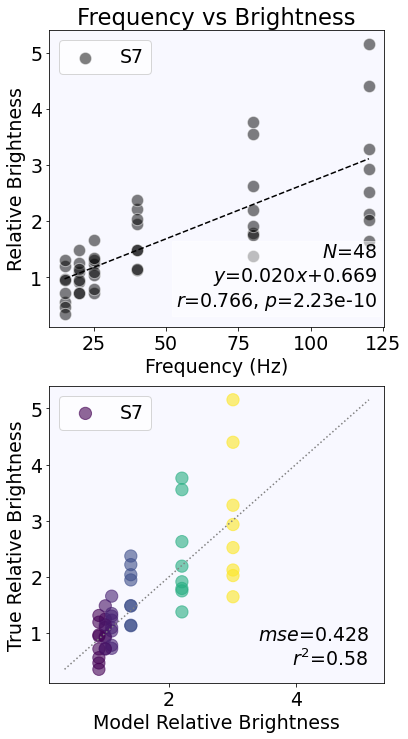

In [571]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12))
plt.sca(axes[0])
markersize=150
plt.rcParams['font.size'] = '19'
scatter_correlation(nan_data.freq, nan_data.brightness / 10, show_slope_intercept=True, marker_alpha=0, text_size=19)#, color=nan_data.freq)
plt.scatter(nan_data.freq, nan_data.brightness / 10, label='S7', color='k', edgecolor='w', s=markersize, alpha=0.5)
axes[0].set_facecolor('ghostwhite')
axes[1].set_facecolor('ghostwhite')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Relative Brightness")
plt.title("Frequency vs Brightness")

plt.sca(axes[1])
model = BiphasicAxonMapModel()
model.a3, model.a4 = 0.010781075631594151, 0.13401318508000498
implant = ArgusI(rot=-79.3)
model.build()

nan_data['phosphene'] = nan_data.apply(get_percept_nanduri, args=(model, implant), axis=1)
nan_data['ref_phosphene'] = nan_data.apply(get_ref_percept_nanduri, args=(model, implant), axis=1)
nan_data['model_rel_bright'] = nan_data.phosphene.apply(phosphene_bright) / nan_data.ref_phosphene.apply(phosphene_bright)

maxval = max(nan_data.model_rel_bright.max(), (nan_data.brightness / 10).max())
pltmax = min(nan_data.model_rel_bright.max(), (nan_data.brightness / 10).max())
pltmin = min(nan_data.model_rel_bright.min(), (nan_data.brightness / 10).min())
plt.plot([pltmin, maxval], [pltmin, maxval], linestyle=':', color='gray')
im = plt.scatter(nan_data.model_rel_bright, nan_data.brightness / 10, c=nan_data.freq, alpha=0.6, s=markersize, label='S7')
plt.legend()
plt.ylabel("True Relative Brightness")
plt.xlabel("Model Relative Brightness")
# plt.title("S0")
# for x, y, elec in zip(nan_data.model_rel_bright, nan_data.brightness/10, nan_data.electrode):
#         plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
# plt.colorbar(label='Frequency')

mse = np.mean((nan_data.model_rel_bright - nan_data.brightness / 10)**2)
r = r2_score(nan_data.brightness / 10, nan_data.model_rel_bright)
t = plt.text(maxval, pltmin, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')


# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.93, 0.14, 0.04, 0.75])#0.30, 0.08, 0.4])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.set_label("Frequency (Hz)")
plt.savefig('figures/freqvbright.png',bbox_inches='tight', dpi=800)
fig_fvb = fig
axes_fvb = axes

In [51]:
def nan_mse(params, nandata, model):
    model.a3 = params[0]
    model.a4=params[1]
    implant = ArgusI(rot=params[2])
    ytrue = nandata.brightness / 10
    nandata['phosphene'] = nandata.apply(get_percept_nanduri, args=(model, implant), axis=1)
    ypred = nandata.phosphene.apply(phosphene_bright) / nandata.ref_phosphene.apply(phosphene_bright)
    return 1 - r2_score(ytrue, ypred)

In [52]:
# sol = differential_evolution(nan_mse, ((0, 0.5), (-5, 5), (-180, 180)), args=(nan_data, model), maxiter=100, popsize=10, callback = lambda x, convergence=None : print(x))

In [53]:
# print(sol)

## Amp vs Brightness

In [55]:
from pulse2percept.datasets import load_greenwald2009
green_data = load_greenwald2009()
green_data.head()

,subject,implant,electrode,task,stim_class,stim_dur,amp,brightness,pulse_dur,interphase_dur,pulse_type,threshold
0,S05,ArgusI,B2,rate,Greenwald2009,0.2,41.328160,1.049167,0.000975,0.000975,cathodicfirst,20.688
1,S05,ArgusI,B2,rate,Greenwald2009,0.2,29.805000,1.552139,0.000975,0.000975,cathodicfirst,20.688
2,S05,ArgusI,B2,rate,Greenwald2009,0.2,52.713788,2.939241,0.000975,0.000975,cathodicfirst,20.688
3,S05,ArgusI,B2,rate,Greenwald2009,0.2,38.842772,4.294906,0.000975,0.000975,cathodicfirst,20.688
4,S05,ArgusI,B2,rate,Greenwald2009,0.2,68.637949,5.858834,0.000975,0.000975,cathodicfirst,20.688


In [56]:
def get_percept_greenwald(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(1, row.amp / row.threshold, row.pulse_dur * 1000)}
    return model.predict_percept(implant)
def get_ref_percept_greenwald(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(1, 2.5, row.pulse_dur * 1000)}
    return model.predict_percept(implant)

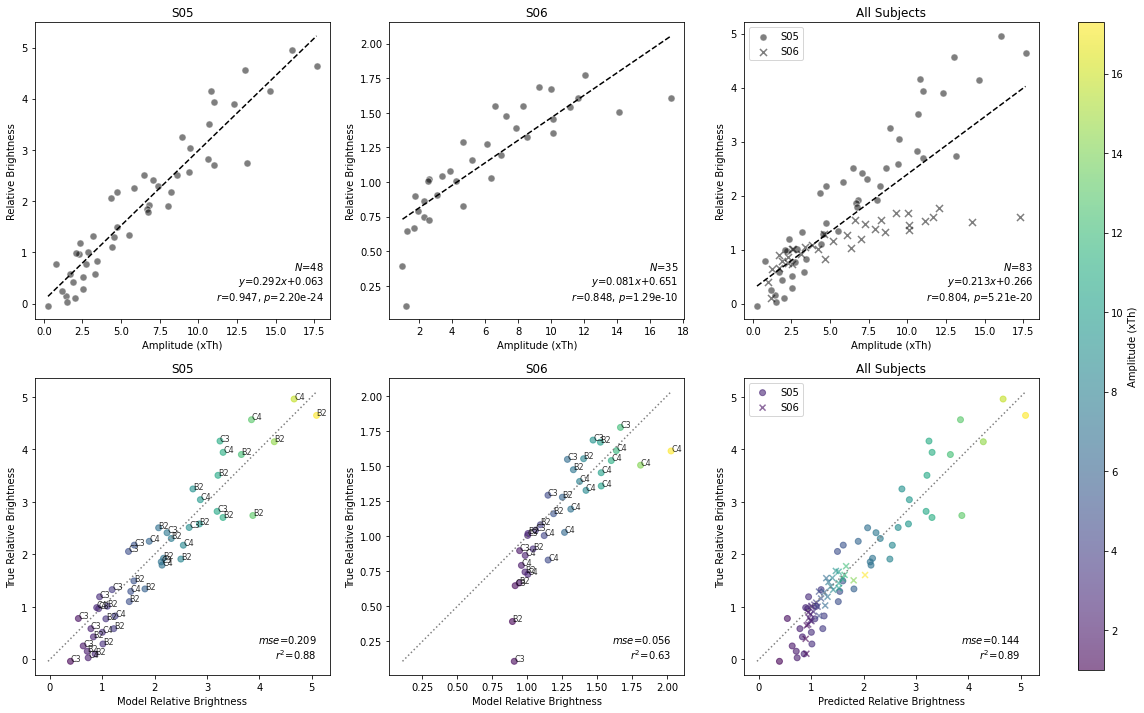

In [356]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
all_model_brights = []
all_brights = []
all_amps = []
for i, subject in enumerate(green_data.subject.unique()):
    df = green_data[green_data.subject == subject]
    amps = df.amp / df.threshold
    
    plt.sca(axes[0, i])
    
    scatter_correlation(amps, df.brightness / 10, show_slope_intercept=True)#, color=nan_data.freq)
    plt.xlabel("Amplitude (xTh)")
    plt.ylabel("Relative Brightness")
    plt.title(subject)

    plt.sca(axes[1, i])
    model = BiphasicAxonMapModel(engine='jax')
    if subject == 'S05':
        model.a2, model.a4 = 0.4, 0.99
        implant = ArgusI()
    # model.a3, model.a4 = 0.010781075631594151, 0.13401318508000498
    elif subject == 'S06':
        model.a2, model.a4 = 0.04, 0.98
        implant = ArgusI(rot=0)
    model.build()

    df['phosphene'] = df.apply(get_percept_greenwald, args=(model, implant), axis=1)
    df['ref_phosphene'] = df.apply(get_ref_percept_greenwald, args=(model, implant), axis=1)
    df['model_rel_bright'] = df.phosphene.apply(phosphene_bright) / df.ref_phosphene.apply(phosphene_bright)

    maxval = max(df.model_rel_bright.max(), (df.brightness / 10).max())
    pltmax = min(df.model_rel_bright.max(), (df.brightness / 10).max())
    pltmin = min(df.model_rel_bright.min(), (df.brightness / 10).min())
    plt.plot([pltmin, maxval], [pltmin, maxval], linestyle=':', color='gray')
    im = plt.scatter(df.model_rel_bright, df.brightness / 10, c=amps, alpha=0.6)
    plt.ylabel("True Relative Brightness")
    plt.xlabel("Model Relative Brightness")
    plt.title(subject)
    for x, y, elec in zip(df.model_rel_bright, df.brightness/10, df.electrode):
            plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
    # plt.colorbar(label='Frequency')

    mse = np.mean((df.model_rel_bright - df.brightness / 10)**2)
    r = r2_score(df.brightness / 10, df.model_rel_bright)
    t = plt.text(maxval, pltmin, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')

    all_model_brights.append(np.array(df.model_rel_bright))
    all_brights.append(np.array(df.brightness / 10))
    all_amps.append(amps)


plt.sca(axes[0, 2])
scatter_correlation(green_data.amp / green_data.threshold, green_data.brightness / 10, show_slope_intercept=True, marker_alpha=0)
for subject, marker in zip(green_data.subject.unique(), ['o', 'x']):
    df = green_data[green_data.subject == subject]
    plt.scatter(df.amp / df.threshold, df.brightness/10, marker=marker, label=subject, color='k', alpha=0.5, edgecolors='w', s=50)
plt.legend()
plt.xlabel("Amplitude (xTh)")
plt.ylabel("Relative Brightness")
plt.title("All Subjects")

plt.sca(axes[1, 2])
for subject, model_vals, vals, amps, marker in zip(green_data.subject.unique(), all_model_brights, all_brights, all_amps, ['o', 'x']):
    im = plt.scatter(model_vals, vals, c=amps, marker=marker, label=subject, alpha=0.6)
plt.xlabel("Predicted Relative Brightness")
plt.ylabel("True Relative Brightness")
plt.title("All Subjects")
plt.legend()
maxval = max([d.max() for d in all_model_brights] + [d.max() for d in all_brights])
pltmax = min([d.max() for d in all_model_brights] + [d.max() for d in all_brights])
pltmin = min([d.min() for d in all_model_brights] + [d.min() for d in all_brights])
plt.plot([pltmin, maxval], [pltmin, maxval], linestyle=':', color='gray')


all_model = np.concatenate(all_model_brights)
brights = np.concatenate(all_brights)
mse = np.mean((all_model - brights)**2)
r = r2_score(brights, all_model)
t = plt.text(5, pltmin, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.13, 0.02, 0.75])#0.30, 0.08, 0.4])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("Amplitude (xTh)")

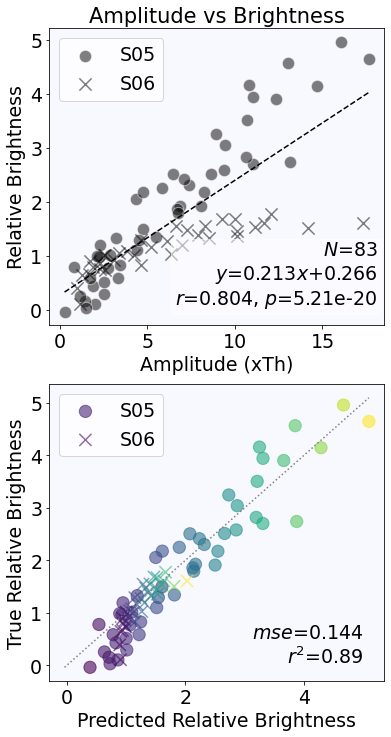

In [572]:
markersize=150
plt.rcParams['font.size'] = '19'

fig, axes = plt.subplots(2, 1, figsize=(6, 12))
axes[0].set_facecolor('ghostwhite')
axes[1].set_facecolor('ghostwhite')
all_model_brights = []
all_brights = []
all_amps = []
for i, subject in enumerate(green_data.subject.unique()):
    df = green_data[green_data.subject == subject]
    amps = df.amp / df.threshold
    
#     plt.sca(axes[0, i])
    
#     scatter_correlation(amps, df.brightness / 10, show_slope_intercept=True)#, color=nan_data.freq)
#     plt.xlabel("Amplitude (xTh)")
#     plt.ylabel("Relative Brightness")
#     plt.title(subject)

#     plt.sca(axes[1, i])
    model = BiphasicAxonMapModel(engine='jax')
    if subject == 'S05':
        model.a2, model.a4 = 0.4, 0.99
        implant = ArgusI()
    # model.a3, model.a4 = 0.010781075631594151, 0.13401318508000498
    elif subject == 'S06':
        model.a2, model.a4 = 0.04, 0.98
        implant = ArgusI(rot=0)
    model.build()

    df['phosphene'] = df.apply(get_percept_greenwald, args=(model, implant), axis=1)
    df['ref_phosphene'] = df.apply(get_ref_percept_greenwald, args=(model, implant), axis=1)
    df['model_rel_bright'] = df.phosphene.apply(phosphene_bright) / df.ref_phosphene.apply(phosphene_bright)

#     maxval = max(df.model_rel_bright.max(), (df.brightness / 10).max())
#     pltmax = min(df.model_rel_bright.max(), (df.brightness / 10).max())
#     pltmin = min(df.model_rel_bright.min(), (df.brightness / 10).min())
#     plt.plot([pltmin, maxval], [pltmin, maxval], linestyle=':', color='gray')
#     im = plt.scatter(df.model_rel_bright, df.brightness / 10, c=amps, alpha=0.6)
#     plt.ylabel("True Relative Brightness")
#     plt.xlabel("Model Relative Brightness")
#     plt.title(subject)
#     for x, y, elec in zip(df.model_rel_bright, df.brightness/10, df.electrode):
#             plt.annotate(elec, (x,y), fontsize=8, alpha=0.8)
#     # plt.colorbar(label='Frequency')

#     mse = np.mean((df.model_rel_bright - df.brightness / 10)**2)
#     r = r2_score(df.brightness / 10, df.model_rel_bright)
#     t = plt.text(maxval, pltmin, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')

    all_model_brights.append(np.array(df.model_rel_bright))
    all_brights.append(np.array(df.brightness / 10))
    all_amps.append(amps)


plt.sca(axes[0])
scatter_correlation(green_data.amp / green_data.threshold, green_data.brightness / 10, show_slope_intercept=True, marker_alpha=0, text_size=19)
for subject, marker in zip(green_data.subject.unique(), ['o', 'x']):
    df = green_data[green_data.subject == subject]
    plt.scatter(df.amp / df.threshold, df.brightness/10, marker=marker, label=subject, color='k', alpha=0.5, edgecolors='w', s=markersize)
plt.legend()
plt.xlabel("Amplitude (xTh)", fontsize=19)
plt.ylabel("Relative Brightness", fontsize=19)
plt.title("Amplitude vs Brightness", fontsize=21)

plt.sca(axes[1])
for subject, model_vals, vals, amps, marker in zip(green_data.subject.unique(), all_model_brights, all_brights, all_amps, ['o', 'x']):
    im = plt.scatter(model_vals, vals, c=amps, marker=marker, label=subject, alpha=0.6, s=markersize)
plt.xlabel("Predicted Relative Brightness")
plt.ylabel("True Relative Brightness")
# plt.title("All Subjects")
plt.legend()
maxval = max([d.max() for d in all_model_brights] + [d.max() for d in all_brights])
pltmax = min([d.max() for d in all_model_brights] + [d.max() for d in all_brights])
pltmin = min([d.min() for d in all_model_brights] + [d.min() for d in all_brights])
plt.plot([pltmin, maxval], [pltmin, maxval], linestyle=':', color='gray')


all_model = np.concatenate(all_model_brights)
brights = np.concatenate(all_brights)
mse = np.mean((all_model - brights)**2)
r = r2_score(brights, all_model)
t = plt.text(5, pltmin, f"$mse$={mse:.3f}\n $r^2$={r:.2f}", va='bottom', ha='right')

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.93, 0.13, 0.05, 0.75])#0.30, 0.08, 0.4])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.set_label("Amplitude (xTh)")
plt.savefig('figures/ampvbright.png',bbox_inches='tight', dpi=800)
fig_avb = fig
axes_avb = axes

In [147]:
def green_mse(params, greendata, model):
    model.a2 = params[0]
    model.a4 = params[1]
    implant = ArgusI()
    # model.a0 = params[3]
    # model.a1 = params[4]
    ytrue = greendata.brightness / 10
    greendata['phosphene'] = greendata.apply(get_percept_greenwald, args=(model, implant), axis=1)
    greendata['ref_phosphene'] = greendata.apply(get_ref_percept_greenwald, args=(model, implant), axis=1)
    ypred = greendata.phosphene.apply(phosphene_bright) / greendata.ref_phosphene.apply(phosphene_bright)
    
    return 1 - r2_score(ytrue, ypred)
    # return np.mean((ytrue - ypred)**2) 

In [148]:
# sols = {}
# for subject in green_data.subject.unique():
#     print(subject)
#     df = green_data[green_data.subject == subject]
#     model = BiphasicAxonMapModel()
#     model.build()
#     # print(green_mse([ model.a2, model.a4, 0, model.a0, model.a1], df, model))
#     sol = differential_evolution(green_mse, ((0, 1), (-0.05, 1)), args=(df, model), maxiter=100, popsize=25)
#     print(sol)
#     sols[subject] = sol
#     print(green_mse(sol.x, df, model))
#     # print()

S05
     fun: 0.11553145836224488
 message: 'Optimization terminated successfully.'
    nfev: 403
     nit: 7
 success: True
       x: array([0.33, 0.82])
0.11553145836224488
S06
     fun: 0.35860922758733693
     jac: array([-0.54,  0.  ])
 message: 'Optimization terminated successfully.'
    nfev: 925
     nit: 16
 success: True
       x: array([0.03, 0.75])
0.35860922758733693


## Pulse Duration

In [9]:
from pulse2percept.datasets import load_horsager2009
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
hdata = load_horsager2009(stim_types=['single_pulse'])
hdata.head()

,subject,implant,electrode,task,stim_type,stim_dur,stim_freq,stim_amp,pulse_type,pulse_dur,...,interphase_dur,delay_dur,ref_stim_type,ref_freq,ref_amp,ref_amp_factor,ref_pulse_dur,ref_interphase_dur,theta,source
0,S05,ArgusI,C3,threshold,single_pulse,200.0,NaN,179.792755,cathodic_first,0.075,...,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,fig_3
1,S05,ArgusI,C3,threshold,single_pulse,200.0,NaN,97.391689,cathodic_first,0.150,...,0.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,fig_3
2,S05,ArgusI,C3,threshold,single_pulse,200.0,NaN,64.690443,cathodic_first,0.220,...,0.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,fig_3
3,S05,ArgusI,C3,threshold,single_pulse,200.0,NaN,33.039171,cathodic_first,0.530,...,0.530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,fig_3
4,S05,ArgusI,C3,threshold,single_pulse,200.0,NaN,29.333355,cathodic_first,0.750,...,0.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.3,fig_3


In [10]:
def get_reference_horsager(row):
    return hdata[(hdata['subject'] == row.subject) & (hdata['electrode'] == row.electrode) & (hdata['pulse_dur'] == 0.53)]['stim_amp'].iloc[0]
hdata['scaled_threshold'] = hdata.stim_amp / hdata.apply(get_reference_horsager, axis=1)
def get_percept_nanduri(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(row.freq, row.amp_factor, row.pulse_dur)}
    return model.predict_percept(implant)
def get_ref_percept_nanduri(row, model, implant):
    implant.stim = {row.electrode : BiphasicPulseTrain(row.ref_freq, row.ref_amp_factor, row.pulse_dur)}
    return model.predict_percept(implant)

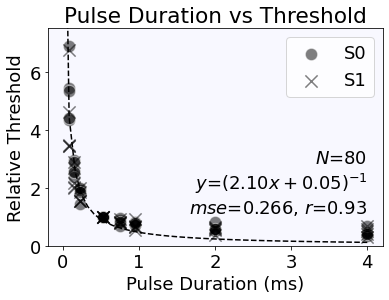

In [13]:
markersize=150
plt.rcParams['font.size'] = '18'
plt.gca().set_facecolor('ghostwhite')
for subject, marker, label in zip(hdata.subject.unique(), ['o', 'x'], ['S0', 'S1']):
    df = hdata[hdata.subject == subject]
    plt.scatter(df['pulse_dur'], df['scaled_threshold'], alpha=0.5, color='k', edgecolors='w', marker=marker, label=label, s=markersize)
plt.legend()
def fit_thresh(pdur, a0, a1):
    return 1 / (a1 + a0 * pdur)
a = curve_fit(fit_thresh, hdata['pulse_dur'], hdata['scaled_threshold'])
pred_thresh = hdata.pulse_dur.apply(fit_thresh, args=(a[0][0], a[0][1]))
mse = np.mean((pred_thresh - hdata.scaled_threshold)**2)
r = np.sqrt(r2_score(hdata.scaled_threshold, pred_thresh))
t = plt.text(4, 1, f"$N$={len(hdata.pulse_dur)}\n$y$=$({a[0][0]:.2f}x+{a[0][1]:.2f})^{{-1}}$\n$mse$={mse:.3f}, $r$={r:.2f}", va='bottom', ha='right')
xs = np.linspace(0, hdata.pulse_dur.max())
ys = fit_thresh(xs, a[0][0], a[0][1])
plt.plot(xs, ys, 'k--')
plt.ylim(0, 7.5)
plt.xlabel("Pulse Duration (ms)")
plt.ylabel('Relative Threshold')
plt.title("Pulse Duration vs Threshold")
plt.savefig('figures/pdurvthresh.png', bbox_inches='tight', dpi=250)

In [212]:
ndata = load_nanduri2012(task='rate')
ndata= ndata[ndata.varied_param == 'amp']
gdata = load_greenwald2009()

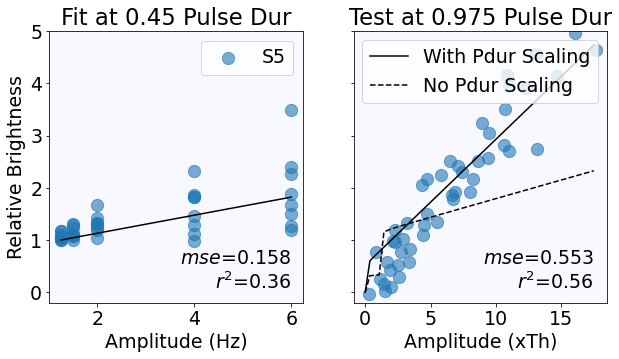

In [601]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plt.sca(axes[0])
plt.gca().set_facecolor('ghostwhite')
plt.scatter(ndata.amp_factor, ndata['brightness'] / 10, s=markersize, alpha=0.6, label='S5')
plt.xlabel("Amplitude (Hz)")
plt.ylabel("Relative Brightness")
plt.title("Fit at 0.45 Pulse Dur")
plt.ylim(-0.2, 5)
plt.legend()

model = BiphasicAxonMapModel()
model.a2, model.a4 = 0.291, 0.996
# model.a2 = 0.134 
# model.a4 = 0.109
model.build()
implant = ArgusI()

ndata['ref_phosphene'] = ndata.apply(get_ref_percept_nanduri, axis=1, args=(model, implant))
ndata['phosphene'] = ndata.apply(get_percept_nanduri, axis=1, args=(model, implant))
ndata['model_rel_bright'] = ndata['phosphene'].apply(phosphene_bright) / ndata['ref_phosphene'].apply(phosphene_bright)
mse = np.mean((ndata['model_rel_bright'] - ndata['brightness']/10)**2)
r = r2_score(ndata['brightness']/10, ndata['model_rel_bright'])


implant.stim = {'A2' : BiphasicPulseTrain(20, 1.25, 0.45)}
ref_phosphene_bright = phosphene_bright(model.predict_percept(implant)) 
amps = ndata.amp_factor.unique()
model_brights = []
for amp in amps:
    implant.stim = {'A2' : BiphasicPulseTrain(20, amp, 0.45)}
    model_brights.append(phosphene_bright(model.predict_percept(implant)) / ref_phosphene_bright)
plt.plot(amps, model_brights, color='k')
t = plt.text(6, 0, f"$mse$={mse:.3f}\n$r^2$={r:.2f}", va='bottom', ha='right')

plt.sca(axes[1])
gd = gdata[gdata.subject == 'S05']
plt.scatter(gd.amp / gd.threshold, gd.brightness / 10, s=markersize, alpha=0.6)


implant.stim = {'A2' : BiphasicPulseTrain(1, 2.5, 0.975)}
ref_phosphene_bright = phosphene_bright(model.predict_percept(implant)) 
amps = np.linspace(0, 17.5)
green_brights = []
for amp in amps:
    implant.stim = {'A2' : BiphasicPulseTrain(20, amp, 0.975)}
    green_brights.append(phosphene_bright(model.predict_percept(implant)) / ref_phosphene_bright)
    
gdata['ref_phosphene'] = gdata.apply(get_ref_percept_greenwald, axis=1, args=(model, implant))
gdata['phosphene'] = gdata.apply(get_percept_greenwald, axis=1, args=(model, implant))
gdata['model_rel_bright'] = gdata['phosphene'].apply(phosphene_bright) / gdata['ref_phosphene'].apply(phosphene_bright)
mse = np.mean((gdata['model_rel_bright'] - gdata['brightness']/10)**2)
r = r2_score(gdata['brightness']/10, gdata['model_rel_bright'])
t = plt.text(17.5, 0, f"$mse$={mse:.3f}\n$r^2$={r:.2f}", va='bottom', ha='right')
plt.plot(amps, green_brights, color='k', label='With Pdur Scaling')

model.a0 = 0.25
model.build()
implant.stim = {'A2' : BiphasicPulseTrain(1, 2.5, 0.975)}
ref_phosphene_bright = phosphene_bright(model.predict_percept(implant)) 
amps = np.linspace(0, 17.5)
bad_green_brights = []
# model.a0=0
# model.a1=0
for amp in amps:
    implant.stim = {'A2' : BiphasicPulseTrain(20, amp, 0.975)}
    bad_green_brights.append(phosphene_bright(model.predict_percept(implant)) / ref_phosphene_bright)
plt.plot(amps, bad_green_brights, color='k', linestyle='--', label='No Pdur Scaling')
plt.legend()

plt.gca().set_facecolor('ghostwhite')
plt.xlabel("Amplitude (xTh)")
plt.title("Test at 0.975 Pulse Dur")

plt.savefig('figures/pdur_scaling.png', dpi=400, bbox_inches='tight')

In [308]:
def mse_g(params, model, gd, nd):
    model.a2 = params[0]
    model.a4 = params[1]
    implant = ArgusI()
    gd['ref_phosphene'] = gd.apply(get_ref_percept_greenwald, axis=1, args=(model, implant))
    gd['phosphene'] = gd.apply(get_percept_greenwald, axis=1, args=(model, implant))
    gd['model_rel_bright'] = gd['phosphene'].apply(phosphene_bright) / gd['ref_phosphene'].apply(phosphene_bright)
    
    nd['ref_phosphene'] = nd.apply(get_ref_percept_nanduri, axis=1, args=(model, implant))
    nd['phosphene'] = nd.apply(get_percept_nanduri, axis=1, args=(model, implant))
    nd['model_rel_bright'] = nd['phosphene'].apply(phosphene_bright) / nd['ref_phosphene'].apply(phosphene_bright)
    
    # mse = np.mean((gd['model_rel_bright'] - gd['brightness']/10)**2)
    r = r2_score(gd['brightness']/10, gd['model_rel_bright']) 
    r2 = r2_score(nd['brightness']/10, nd['model_rel_bright']) 
    return (1 - r) + (1-r2)

In [310]:
# model = BiphasicAxonMapModel()
# model.build()
# sol = differential_evolution(mse_g, ((0, 1),(-0.25, 1)), args=(model, gdata, ndata), popsize=15, maxiter=100)
# print(sol)

     fun: 1.076816904244966
     jac: array([2.633, 0.   ])
 message: 'Optimization terminated successfully.'
    nfev: 492
     nit: 12
 success: True
       x: array([0.291, 0.996])


## Combine

In [593]:
def plot_axes(ax, fig=None, geometry=(1,1,1)):
    if fig is None:
        fig = plt.figure()
    if ax.get_geometry() != geometry :
        ax.change_geometry(*geometry)
    ax = fig.axes.append(ax)
    fig.append
    return fig

In [595]:
plot_axes(axes_avb[0])
plt.show()

<Figure size 432x288 with 0 Axes>

In [582]:
fig.add_subplot(

ValueError: Single argument to subplot must be a three-digit integer, not <AxesSubplot:title={'center':'Amplitude vs Brightness'}, xlabel='Amplitude (xTh)', ylabel='Relative Brightness'>

<Figure size 432x288 with 0 Axes>